In [1]:
import rasterio
import numpy as np
import os
import resnet as rs
import sys
import importlib
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import classifier_utilities as cu

Using TensorFlow backend.


In [42]:
importlib.reload(cu)

<module 'classifier_utilities' from '/host/Desktop/cnn_dev/florence_mapping/classifier_utilities.py'>

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="3";

In [4]:
landsat_datasets, sentinel_datasets, dem_datasets, label_dataset = cu.load_data()

In [23]:
batch_size = 25
epochs = 25
num_classes = len(cu.indexed_dictionary)

# input image dimensions
tile_side = 64
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count + sentinel_datasets[0].count + dem_datasets[0].count - 1

input_shape = (img_bands, img_rows, img_cols)
print(input_shape)

(10, 64, 64)


In [33]:
pixels = cu.gen_balanced_pixel_locations(image_datasets=landsat_datasets, train_count=16*5000, tile_size = tile_side,
                                            label_dataset=label_dataset)

100%|██████████| 5/5 [05:07<00:00, 56.83s/it]


In [34]:
buckets = cu.pixel_balance(pixels, landsat_datasets, label_dataset)
for i in range(len(cu.indexed_dictionary)):
    print("{}:{}".format(cu.indexed_dictionary[i], buckets[i]))

KeyboardInterrupt: 

Water:15613.0
Snow/Ice:0.0
Open Space Developed:18750.0
Low Intensity Developed:0.0
Medium Intensity Developed:18581.0
High Intensity Developed:0.0
Barren Land:11103.0
Deciduous Forest:15020.0
Evergreen Forest:18750.0
Mixed Forest:15420.0
Scrub/Shrub:18750.0
Grassland / Herbaceous:16993.0
Pasture/Hay:15000.0
Cultivated Land:18750.0
Woody Wetland:18750.0
Emergent Herbaceous Wetlands:16607.0


In [12]:
print(len(pixels))

218087


In [13]:
train_px, val_px, test_px = cu.train_val_test_split(pixels, 0.7, 0.7)

In [14]:
print(len(train_px))
print(len(val_px))
print(len(test_px))

152660
45798
33369


In [15]:
import keras
from keras.optimizers import SGD, Adam

In [38]:
model = rs.ResnetBuilder.build_resnet_50(input_shape,num_classes)

In [39]:
opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
model.fit_generator(generator=cu.tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, tile_side, tile_side, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=cu.tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, tile_side, tile_side, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/25
6106/6106 [==============================] - 1777s 291ms/step - loss: 2.5016 - acc: 0.3863 - val_loss: 6.2762 - val_acc: 0.0746
Epoch 2/25
6106/6106 [==============================] - 1747s 286ms/step - loss: 1.8586 - acc: 0.4438 - val_loss: 6.7799 - val_acc: 0.0842
Epoch 3/25
 275/6106 [>.............................] - ETA: 25:07 - loss: 1.7568 - acc: 0.4647

KeyboardInterrupt: 

In [41]:
train_px

[((796, 1368), 1),
 ((249, 2050), 0),
 ((4466, 4472), 2),
 ((2312, 1012), 3),
 ((1237, 2142), 1),
 ((159, 2209), 3),
 ((806, 3644), 0),
 ((2962, 3622), 2),
 ((4127, 1416), 0),
 ((1412, 1327), 3),
 ((3906, 4219), 2),
 ((4870, 316), 1),
 ((2426, 435), 4),
 ((4239, 4344), 0),
 ((1908, 628), 1),
 ((1777, 307), 4),
 ((2292, 1631), 3),
 ((2738, 1377), 1),
 ((389, 2237), 3),
 ((2195, 1491), 3),
 ((2021, 1896), 3),
 ((2667, 1933), 1),
 ((855, 1986), 2),
 ((152, 4084), 3),
 ((2744, 885), 4),
 ((498, 987), 3),
 ((4206, 4360), 2),
 ((1865, 1321), 1),
 ((2586, 3484), 2),
 ((3012, 1043), 1),
 ((3243, 3754), 0),
 ((4584, 664), 1),
 ((2719, 3262), 2),
 ((163, 490), 1),
 ((756, 362), 4),
 ((3986, 1578), 1),
 ((1274, 317), 1),
 ((723, 4043), 2),
 ((1428, 268), 4),
 ((1225, 4027), 0),
 ((2311, 4913), 2),
 ((1230, 1902), 1),
 ((1634, 1890), 1),
 ((1943, 522), 4),
 ((1092, 3063), 2),
 ((2316, 2390), 1),
 ((2650, 1340), 3),
 ((887, 4189), 2),
 ((67, 4419), 2),
 ((901, 3695), 3),
 ((1416, 1881), 0),
 ((907,

# Evaluate on Test Pixels

2385/2385 [==============================] - 669s 280ms/step
[ 9  6 14 ... 11  9 11]
[15 15 15 ... 15 15 15]
ACCURACY
0.07623165618448638


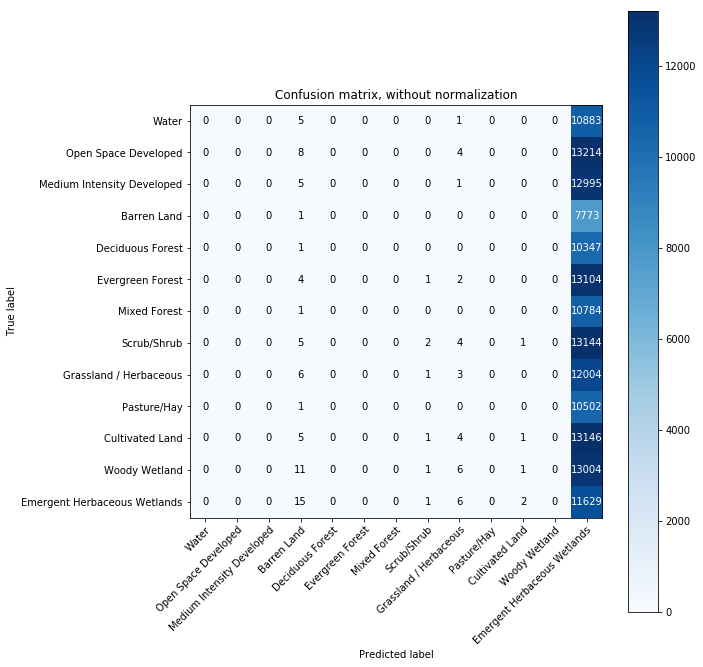

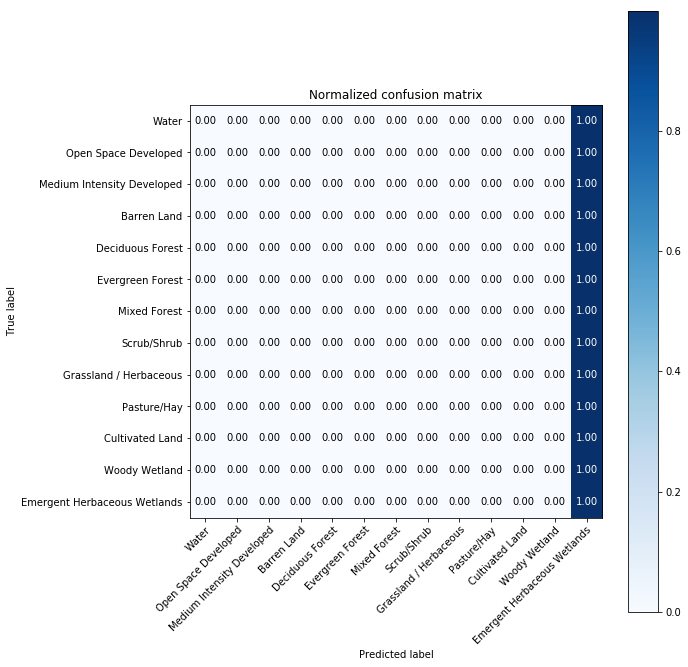

In [43]:
cu.evaluate_cnn(model, landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, tile_side, train_px)

# Make pixels from other tiles (some overlap but general idea on error will be clearer)

In [ ]:
pixels_1 = cu.gen_balanced_pixel_locations(image_datasets=landsat_datasets[0:1], train_count = 100000, tile_size = tile_side,
                                            label_dataset=label_dataset)
pixels_2 = cu.gen_balanced_pixel_locations(image_datasets=landsat_datasets[1:2], train_count = 100000, tile_size = tile_side,
                                            label_dataset=label_dataset)
pixels_3 = cu.gen_balanced_pixel_locations(image_datasets=landsat_datasets[2:3], train_count = 100000, tile_size = tile_side,
                                            label_dataset=label_dataset)
pixels_4 = cu.gen_balanced_pixel_locations(image_datasets=landsat_datasets[3:4], train_count = 100000, tile_size = tile_side,
                                            label_dataset=label_dataset)
pixels_5 = cu.gen_balanced_pixel_locations(image_datasets=landsat_datasets[4:], train_count = 100000, tile_size = tile_side,
                                            label_dataset=label_dataset)

# Evaluate Tile 0

In [ ]:
cu.evaluate_cnn(model, landsat_datasets[0:1], sentinel_datasets[0:1], dem_datasets[0:1], label_dataset, tile_side, pixels_1)

# Evaluate Tile 1

In [ ]:
cu.evaluate_cnn(model, landsat_datasets[1:2], sentinel_datasets[1:2], dem_datasets[1:2], label_dataset, tile_side, pixels_2)

# Evaluate Tile 2

In [ ]:
cu.evaluate_cnn(model, landsat_datasets[2:3], sentinel_datasets[2:3], dem_datasets[2:3], label_dataset, tile_side, pixels_2)

# Evaluate Tile 3

In [ ]:
cu.evaluate_cnn(model, landsat_datasets[3:4], sentinel_datasets[3:4], dem_datasets[3:4], label_dataset, tile_side, pixels_2)

# Evaluate Tile 4

In [ ]:
cu.evaluate_cnn(model, landsat_datasets[4:], sentinel_datasets[4:], dem_datasets[4:], label_dataset, tile_side, pixels_2)